# RdTools tutorial
## Data bounty webinar series
### Michael Deceglie, March 19, 2024

This notebook was presented as part of the SETO Data Bounty Prize webinar series. The tutorial was originally created for RdTools version 2, newer versions will be available in the future.
To acheive a suitable environment to reproduce that demo:
```
conda create --name rdtools_demo python==3.10 notebook==6.4.8 pandas==2.0.3
pip install rise
pip install rdtools==2.1.8
```

In [1]:
import rdtools
import glob
import pvlib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

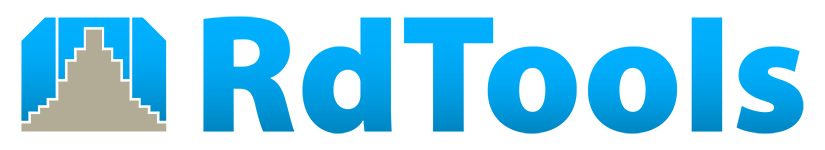

# Degradation analysis with the raw data
## Import the raw data

In [2]:
with open('data/2107_system_metadata.json', 'r') as f:
    metadata = json.load(f)

tz = metadata['System']['timezone_code']

def parse_prize_csv(file, tz):
    df = pd.read_csv(file)
    df.index = pd.to_datetime(df['measured_on'])
    df.index = df.index.tz_localize(tz, ambiguous='NaT')
    df = df.loc[df.index.dropna()].copy()
    print(f'{file} {df.index.min()}:{df.index.max()}')
    return df

df_elect = parse_prize_csv('data/2107_electrical_data.csv', tz)
df_env = parse_prize_csv('data/2107_environment_data.csv', tz)
df_irrad = parse_prize_csv('data/2107_irradiance_data.csv', tz)
df_meter = parse_prize_csv('data/2107_meter_15m_data.csv', tz)

latitude = metadata['Site']['latitude']
longitude = metadata['Site']['longitude']

data/2107_electrical_data.csv 2017-11-01 00:00:00-07:00:2023-11-07 23:55:00-08:00
data/2107_environment_data.csv 2017-12-01 00:00:00-08:00:2023-10-31 23:45:00-07:00
data/2107_irradiance_data.csv 2017-11-01 07:10:00-07:00:2023-11-01 23:55:00-07:00
data/2107_meter_15m_data.csv 2017-01-01 00:15:00-08:00:2023-11-09 23:30:00-08:00


# TrendAnalysis workflow
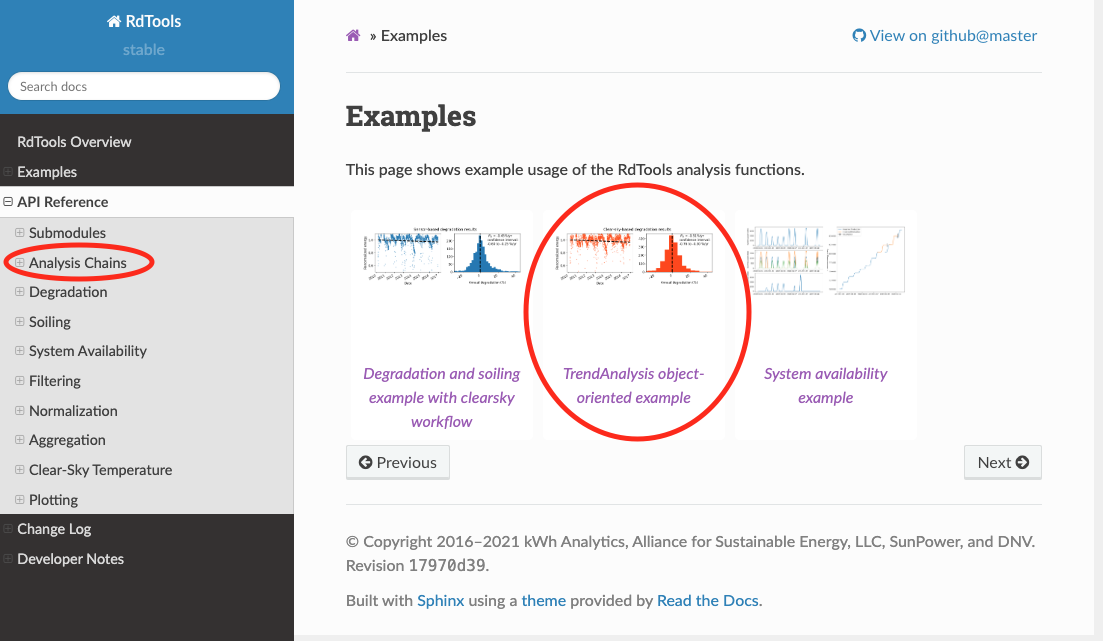

# Use TrendAnalysis to analyze degradation 

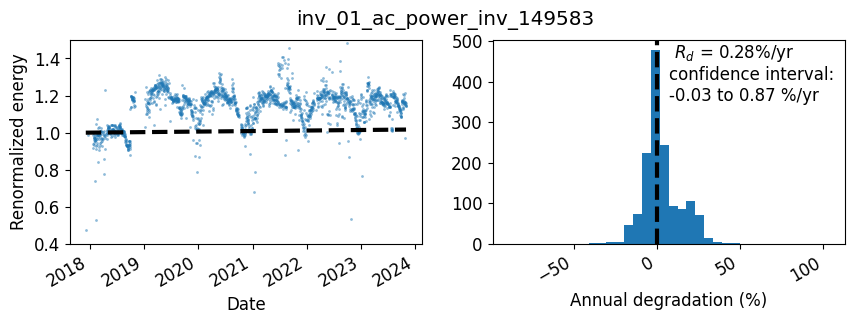

In [3]:
ta = rdtools.TrendAnalysis(df_elect['inv_01_ac_power_inv_149583'],
                           df_irrad['poa_irradiance_o_149574'],
                           temperature_ambient=(df_env['ambient_temperature_o_149575']-32)*(5/9), # convert from F
                           gamma_pdc = -0.0041, # from data sheet
                           windspeed=df_env['wind_speed_o_149576'],
                           temperature_model='open_rack_glass_polymer'
                           )
ta.sensor_analysis(yoy_kwargs={'confidence_level':95})
fig = ta.plot_degradation_summary('sensor', summary_title='inv_01_ac_power_inv_149583', scatter_ymin=0.4, scatter_ymax=1.5)
ax1, ax2 = fig.get_axes()
ax1.collections[0].set_linewidth(0)

# Try again with the data after it has been through QA

In [4]:
irrad_qa = pd.read_pickle('data/poa_irradiance_o_149574.pkl')
wind_qa = pd.read_pickle('data/wind_speed_o_149576.pkl')
inv1_qa = pd.read_pickle('data/inv_01_ac_power_inv_149583.pkl')
temperature_qa= pd.read_pickle('data/ambient_temperature_o_149575.pkl')

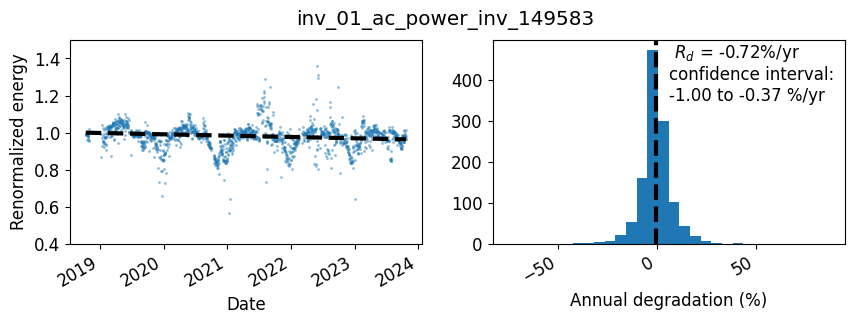

In [5]:
ta = rdtools.TrendAnalysis(inv1_qa,
                           irrad_qa,
                           temperature_ambient=(temperature_qa-32)*(5/9), # convert from F
                           gamma_pdc = -0.0041, # from data sheet
                           windspeed=wind_qa,
                           temperature_model='open_rack_glass_polymer'
                           )
ta.sensor_analysis(yoy_kwargs={'confidence_level':95})
fig = ta.plot_degradation_summary('sensor', summary_title='inv_01_ac_power_inv_149583', scatter_ymin=0.4, scatter_ymax=1.5)
ax1, ax2 = fig.get_axes()
ax1.collections[0].set_linewidth(0)

In [6]:
# Access the results directly 
ta.results

{'sensor': {'yoy_degradation': {'p50_rd': -0.717990363020582,
   'rd_confidence_interval': array([-1.00451315, -0.37415497]),
   'calc_info': {'YoY_values': dt
    2019-10-12 00:00:00-07:00    -1.247479
    2019-10-13 00:00:00-07:00    -1.345516
    2019-10-14 00:00:00-07:00     0.447446
    2019-10-15 00:00:00-07:00    -2.199707
    2019-10-16 00:00:00-07:00     1.124871
                                   ...    
    2023-10-17 00:00:00-07:00    -0.749997
    2023-10-18 00:00:00-07:00   -10.025471
    2023-10-20 00:00:00-07:00    -1.227054
    2023-10-21 00:00:00-07:00    -0.334307
    2023-10-22 00:00:00-07:00     8.148368
    Name: yoy, Length: 1209, dtype: float64,
    'renormalizing_factor': 0.7632266349873552,
    'usage_of_points': dt
    2018-10-12 00:00:00-07:00    1.0
    2018-10-13 00:00:00-07:00    1.0
    2018-10-14 00:00:00-07:00    1.0
    2018-10-15 00:00:00-07:00    1.0
    2018-10-16 00:00:00-07:00    1.0
                                ... 
    2023-10-19 00:00:00-07

# Inspecting and modifying filters

In [7]:
# Take a look at the docstring
# rdtools.TrendAnalysis()
ta.filter_params

{'normalized_filter': {},
 'poa_filter': {},
 'tcell_filter': {},
 'clip_filter': {},
 'csi_filter': {},
 'ad_hoc_filter': None}

In [8]:
start = '2022/05/01'
stop = '2022/05/07'
rdtools.tune_filter_plot(ta.pv_energy.loc[start:stop],
                      ta.sensor_filter_components['clip_filter'].loc[start:stop]) 

In [9]:
ta.filter_params['clip_filter'] = {'model':'logic'}
ta.sensor_analysis(yoy_kwargs={'confidence_level':95})

/Users/mdecegli/opt/anaconda3/envs/oss_webinar/lib/python3.10/site-packages/rdtools/filtering.py:416: UserWarning:

The logic-based filter is an experimental clipping filter that is still under development. The API, results, and default behaviors may change in future releases (including MINOR and PATCH). Use at your own risk!



# We can also turn off the clipping filter

In [10]:
ta.filter_params.pop('clip_filter')
ta.filter_params

{'normalized_filter': {},
 'poa_filter': {},
 'tcell_filter': {},
 'csi_filter': {},
 'ad_hoc_filter': None}

In [11]:
ta.sensor_analysis(yoy_kwargs={'confidence_level':95})

# Let's check back on the result

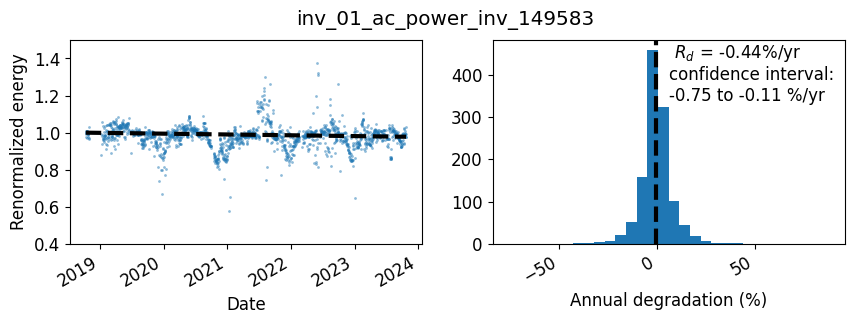

In [12]:
fig = ta.plot_degradation_summary('sensor', summary_title='inv_01_ac_power_inv_149583', scatter_ymin=0.4, scatter_ymax=1.5)
ax1, ax2 = fig.get_axes()
ax1.collections[0].set_linewidth(0)

With the clipping filter removed, we're looking more at the AC degradation. Clipping masks DC degradation.

# Let's take a look at soiling

In [13]:
ta.sensor_analysis(analyses=['yoy_degradation','srr_soiling'],
                   yoy_kwargs={'confidence_level':95},
                   srr_kwargs={'confidence_level':95})

/Users/mdecegli/opt/anaconda3/envs/oss_webinar/lib/python3.10/site-packages/rdtools/soiling.py:14: UserWarning:

The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.

/Users/mdecegli/opt/anaconda3/envs/oss_webinar/lib/python3.10/site-packages/rdtools/soiling.py:366: UserWarning:

20% or more of the daily data is assigned to invalid soiling intervals. This can be problematic with the "half_norm_clean" and "random_clean" cleaning assumptions. Consider more permissive validity criteria such as increasing "max_relative_slope_error" and/or "max_negative_step" and/or decreasing "min_interval_length". Alternatively, consider using method="perfect_clean". For more info see https://github.com/NREL/rdtools/issues/272



In [14]:
yoy_results = ta.results['sensor']['yoy_degradation']
srr_results = ta.results['sensor']['srr_soiling']

In [15]:
srr_results

{'p50_sratio': 0.9573594342582978,
 'sratio_confidence_interval': array([0.93975044, 0.96866323]),
 'calc_info': {'exceedance_level': 0.9438171561382142,
  'renormalizing_factor': 0.7545495189196989,
  'stochastic_soiling_profiles': [date
   2018-10-12 00:00:00-07:00    1.000000
   2018-10-13 00:00:00-07:00    0.998184
   2018-10-14 00:00:00-07:00    0.996367
   2018-10-15 00:00:00-07:00    0.994551
   2018-10-16 00:00:00-07:00    0.992735
                                  ...   
   2023-10-19 00:00:00-07:00    0.952841
   2023-10-20 00:00:00-07:00    0.952841
   2023-10-21 00:00:00-07:00    0.952841
   2023-10-22 00:00:00-07:00    0.952841
   2023-10-23 00:00:00-07:00    0.952841
   Name: stochastic_soiling_profile, Length: 1838, dtype: float64,
   date
   2018-10-12 00:00:00-07:00    1.000000
   2018-10-13 00:00:00-07:00    0.999783
   2018-10-14 00:00:00-07:00    0.999567
   2018-10-15 00:00:00-07:00    0.999350
   2018-10-16 00:00:00-07:00    0.999134
                              

In [16]:
interval_summary = ta.results['sensor']['srr_soiling']['calc_info']['soiling_interval_summary']
interval_summary[interval_summary['valid']].head(10)

start                       end  soiling_rate  \
0  2018-10-12 00:00:00-07:00 2018-10-28 00:00:00-07:00     -0.000740   
7  2019-02-26 00:00:00-08:00 2019-03-12 00:00:00-07:00     -0.003319   
14 2019-09-19 00:00:00-07:00 2019-12-05 00:00:00-08:00     -0.000830   
25 2020-04-18 00:00:00-07:00 2020-05-16 00:00:00-07:00     -0.000513   
29 2020-05-23 00:00:00-07:00 2020-08-15 00:00:00-07:00     -0.000586   
30 2020-08-16 00:00:00-07:00 2020-11-09 00:00:00-08:00     -0.002443   
34 2020-11-17 00:00:00-08:00 2020-12-28 00:00:00-08:00     -0.002139   
40 2021-02-08 00:00:00-08:00 2021-02-15 00:00:00-08:00     -0.004231   
48 2021-07-09 00:00:00-07:00 2021-07-24 00:00:00-07:00     -0.003557   
53 2021-08-19 00:00:00-07:00 2021-10-18 00:00:00-07:00     -0.002251   

    soiling_rate_low  soiling_rate_high  inferred_start_loss  \
0          -0.002496           0.000000             1.001649   
7          -0.009904           0.000000             1.026305   
14         -0.001158          -0.000492             1.013783   
25         -0.001529           0.000000             1.025881   
29         -0.000788          -0.000402             1.032514   
30         -0.002617          -0.002275             1.024833   
34         -0.003035          -0.001204             0.947794   
40         -0.009438           0.000000             1.028590   
48         -0.013582           0.000000             1.172638   
53         -0.002728          -0.001733             1.060077   

    inferred_end_loss  length  valid  
0            0.989811      16   True  
7            0.979845      14   True  
14           0.949870      77   True  
25           1.011519      28   True  
29           0.983272      84   True  
30           0.817158      85   True  
34           0.860104      41   True  
40           0.998973       7   True  
48           1.119285      15   True  
53           0.925012      60   True

# Soiling plots
Soiling intervals

/Users/mdecegli/opt/anaconda3/envs/oss_webinar/lib/python3.10/site-packages/rdtools/plotting.py:225: UserWarning:

The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.



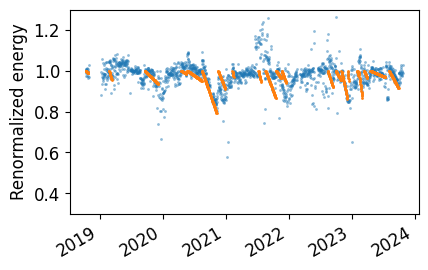

In [17]:
fig = ta.plot_soiling_interval('sensor', ymin=0.3, ymax=1.3);

# Soiling plots
Soiling rate histogram

/Users/mdecegli/opt/anaconda3/envs/oss_webinar/lib/python3.10/site-packages/rdtools/plotting.py:265: UserWarning:

The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.



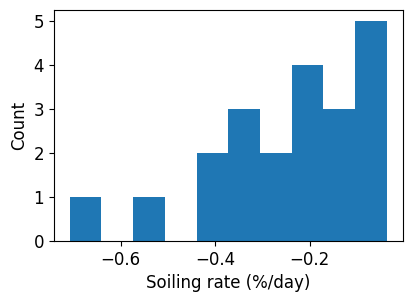

In [18]:
fig = ta.plot_soiling_rate_histogram('sensor', bins=10);

# Soiling plots
Monte Carlo visualization

/Users/mdecegli/opt/anaconda3/envs/oss_webinar/lib/python3.10/site-packages/rdtools/plotting.py:165: UserWarning:

The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.



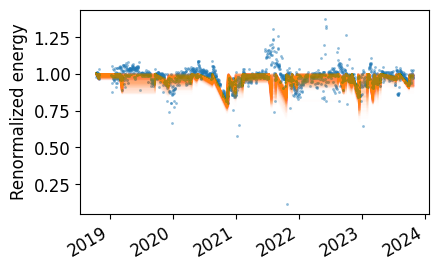

In [19]:
fig = ta.plot_soiling_monte_carlo('sensor', profile_alpha=0.01, profiles=500);

# Soiling summary statistics
Let's look at how to calculate the summary statistics that you will find on NREL's soiling map (https://www.nrel.gov/pv/soiling.html)

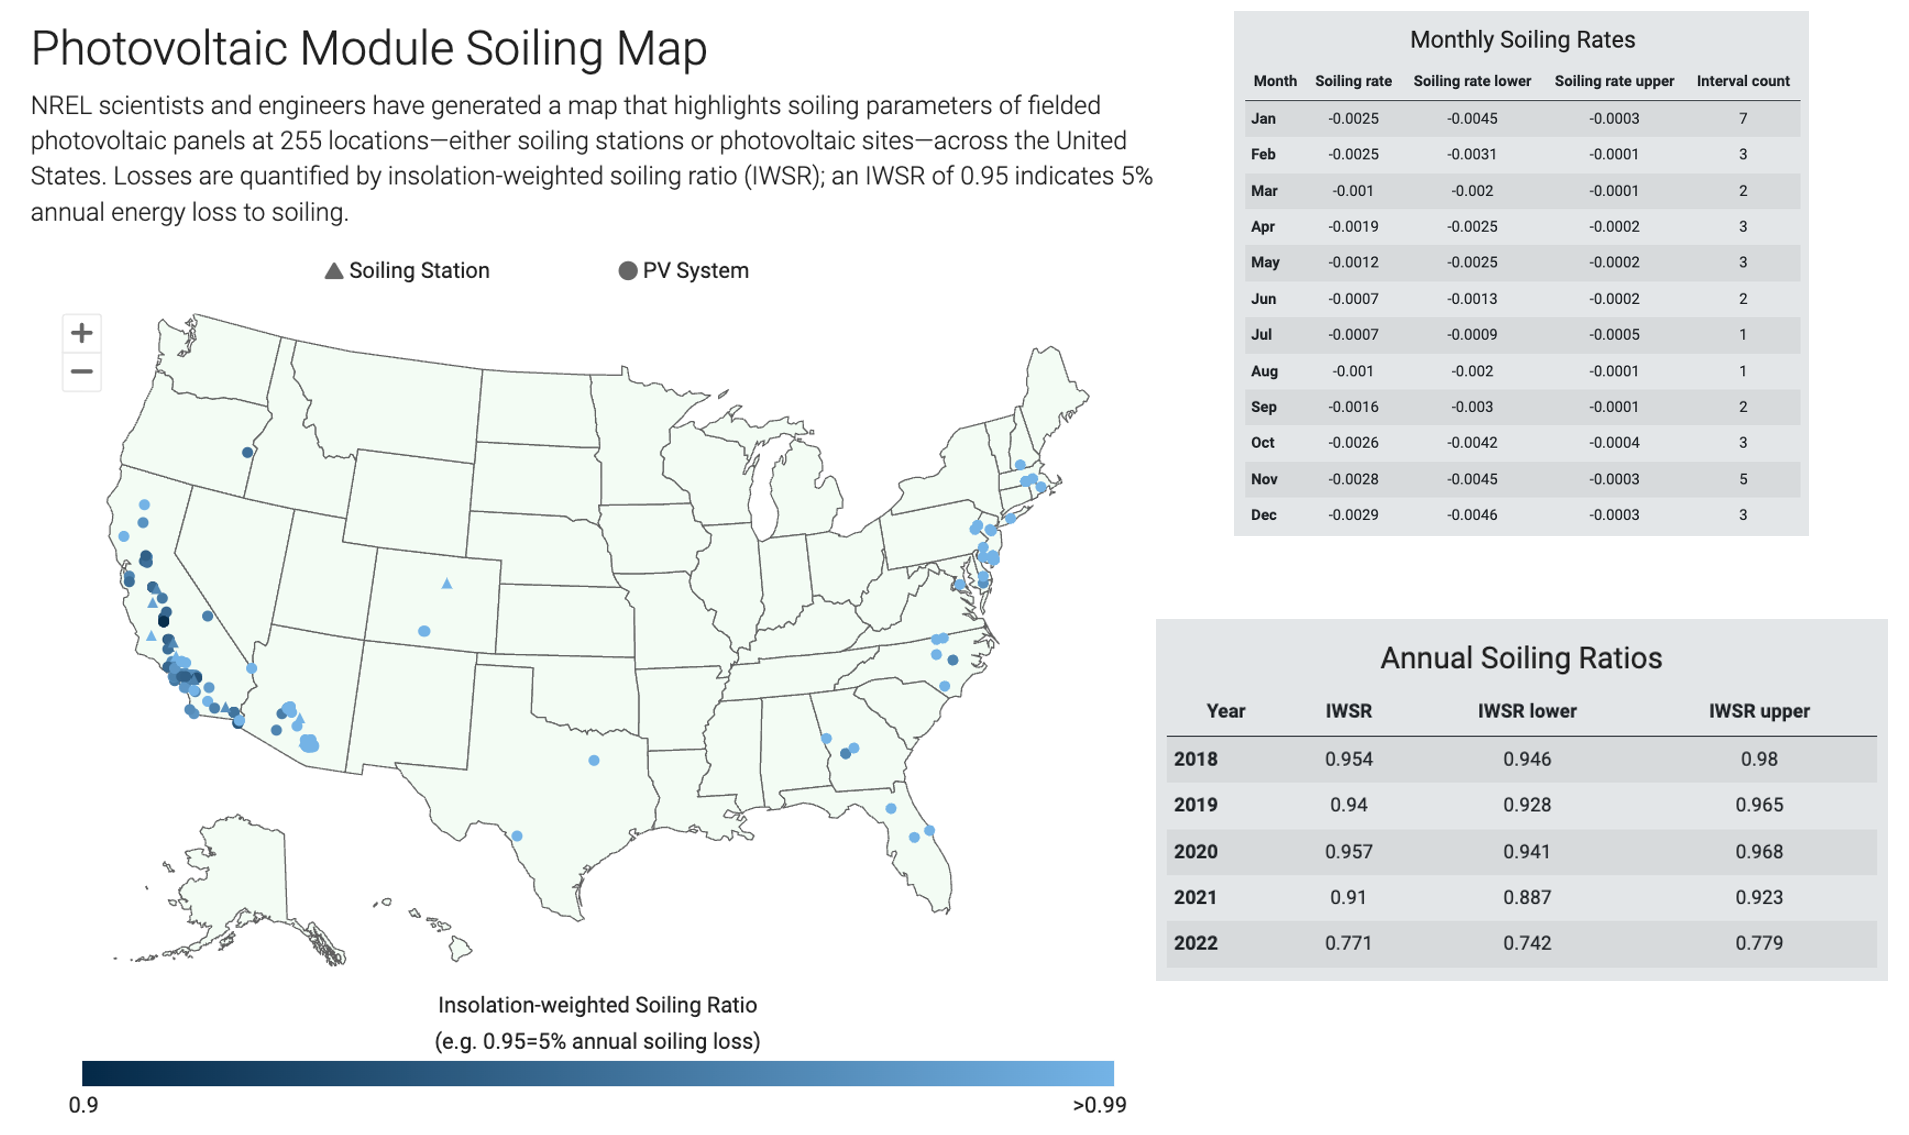

#  Soiling summary statistics
## Monthly soiling rates
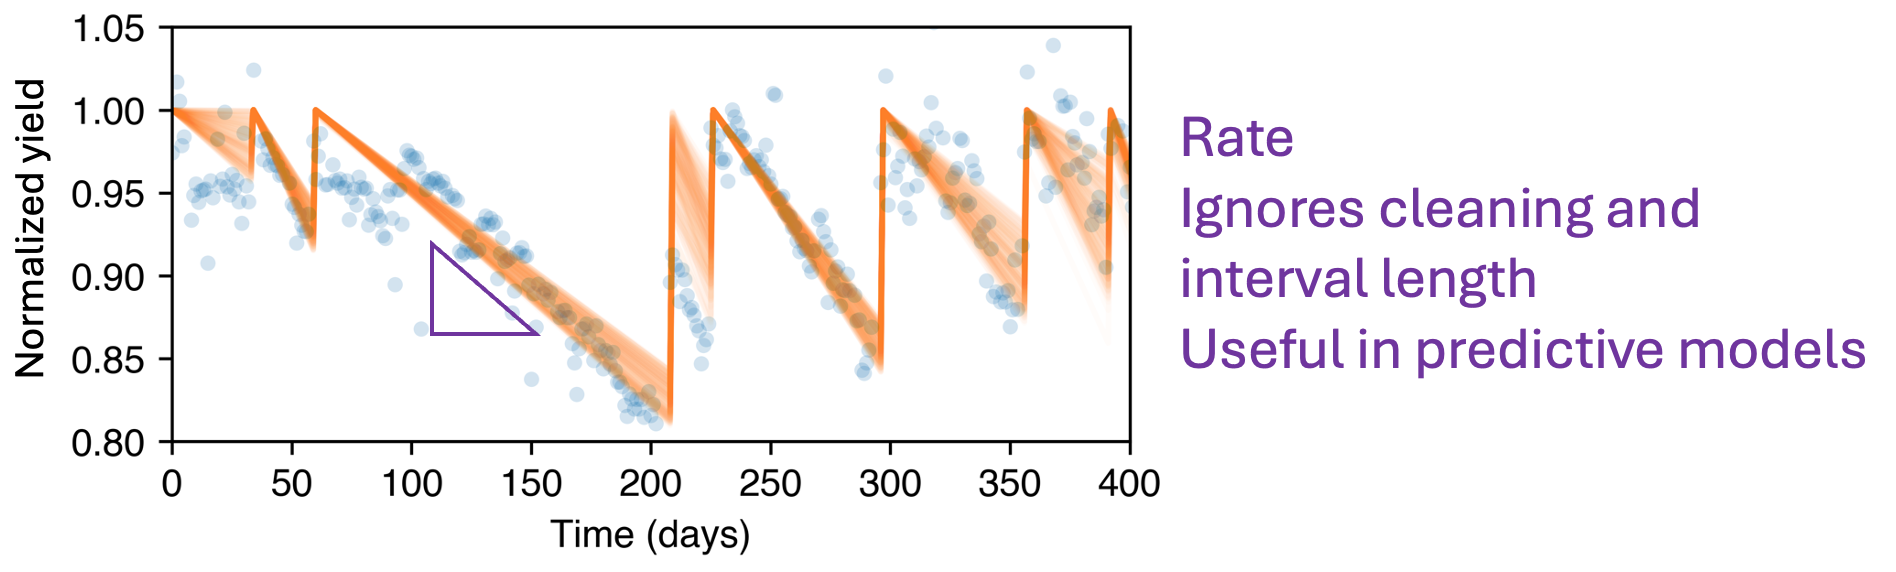

In [20]:
rdtools.soiling.monthly_soiling_rates(interval_summary, confidence_level=95)

month  soiling_rate_median  soiling_rate_low  soiling_rate_high  \
0       1                  NaN               NaN                NaN   
1       2            -0.005917         -0.008580          -0.001914   
2       3            -0.003153         -0.009153          -0.000160   
3       4            -0.000432         -0.001526          -0.000078   
4       5            -0.000428         -0.001394          -0.000137   
5       6            -0.000462         -0.000768          -0.000218   
6       7            -0.000592         -0.012253          -0.000229   
7       8            -0.001730         -0.003784          -0.000459   
8       9            -0.002076         -0.003506          -0.000622   
9      10            -0.001750         -0.002643          -0.000234   
10     11            -0.001981         -0.004462          -0.000392   
11     12            -0.002114         -0.004330          -0.000656   

    interval_count  
0                0  
1                2  
2                3  
3                3  
4                3  
5                2  
6                3  
7                5  
8                6  
9                6  
10               7  
11               4

# Soiling summary statistics
## Annual soiling ratios
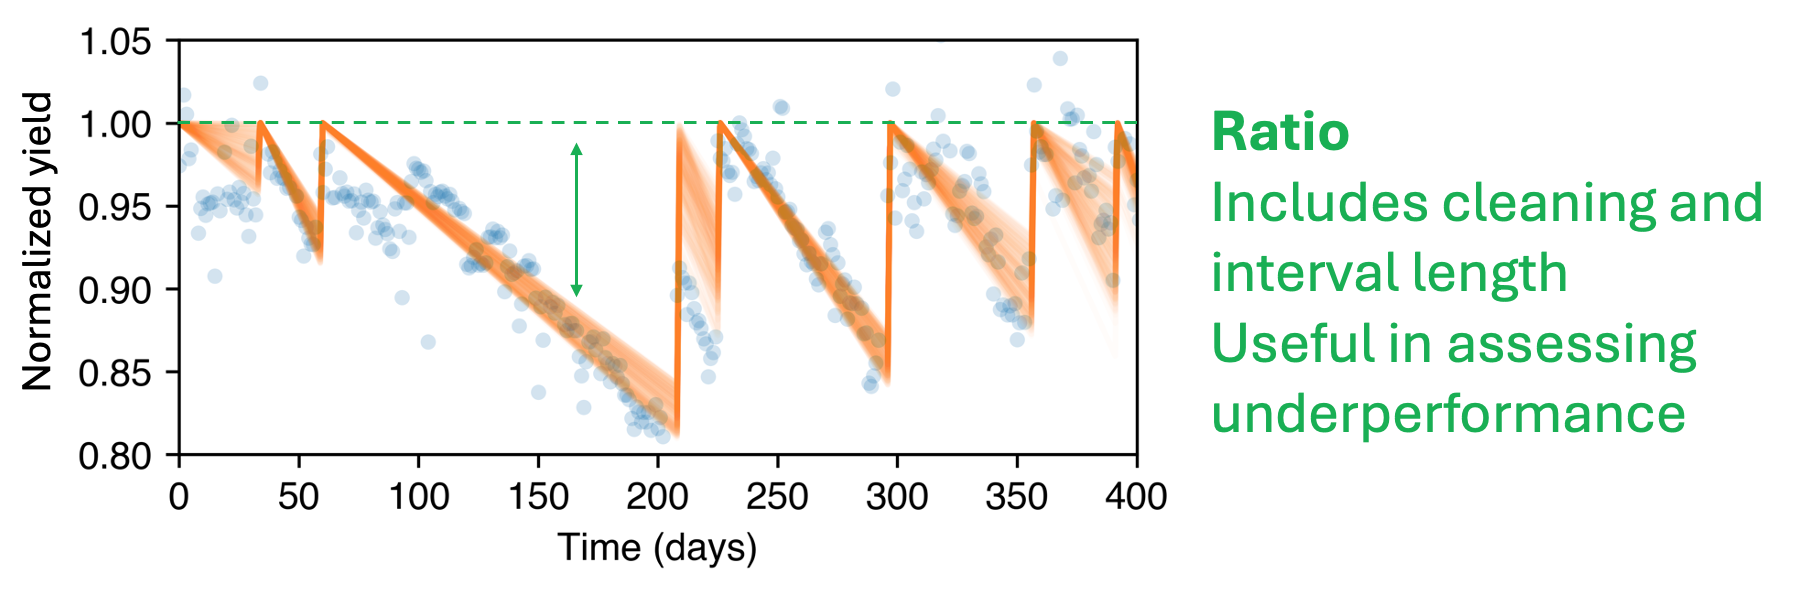

In [21]:
rdtools.soiling.annual_soiling_ratios(ta.results['sensor']['srr_soiling']['calc_info']['stochastic_soiling_profiles'],
                                      ta.sensor_aggregated_insolation,
                                      confidence_level=95)

year  soiling_ratio_median  soiling_ratio_low  soiling_ratio_high
0  2018              0.990947           0.982081            0.999542
1  2019              0.967458           0.908078            0.991381
2  2020              0.948237           0.925721            0.961360
3  2021              0.959526           0.931295            0.976924
4  2022              0.959789           0.916436            0.981862
5  2023              0.961763           0.935805            0.974353

# Let's try swapping in satellite irradiance data
https://nsrdb.nrel.gov/
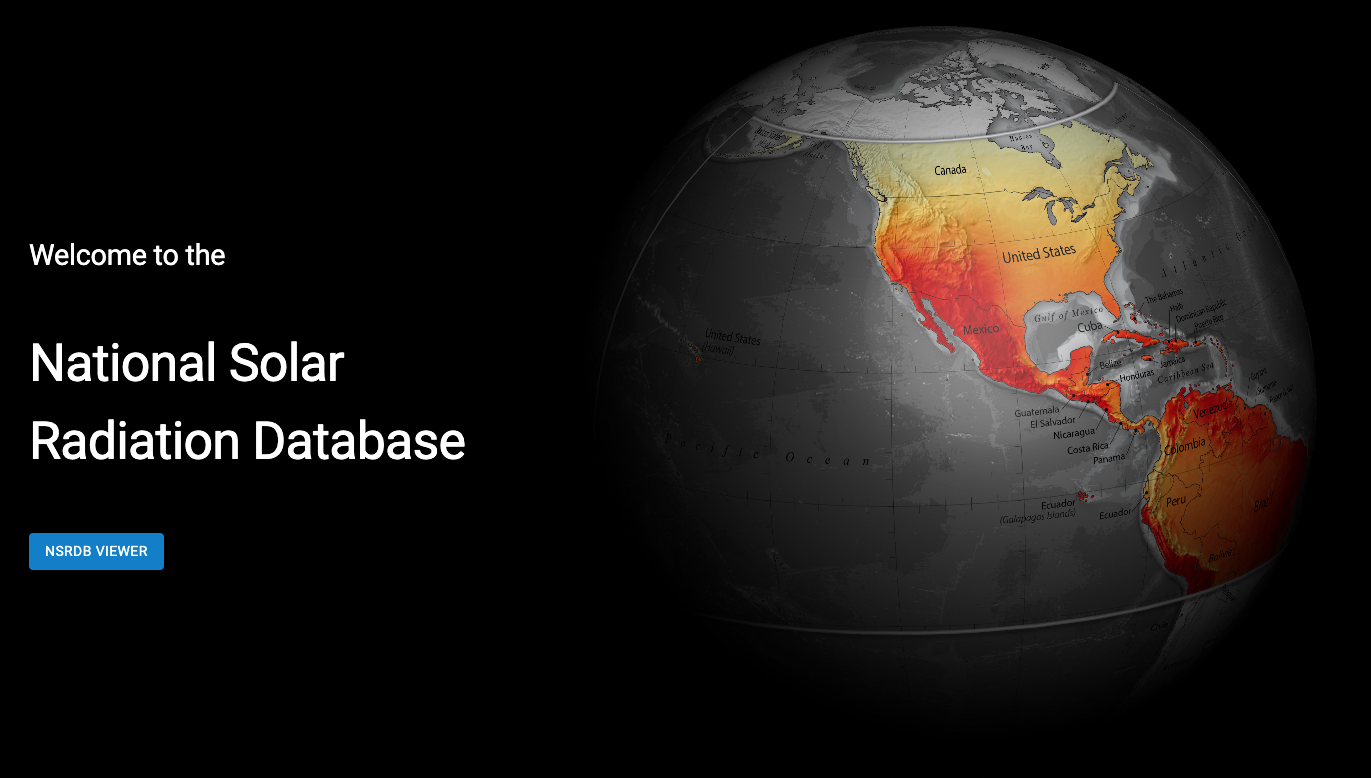

In [22]:
nsrdb_files = glob.glob('data/NSRDB/*.csv')

df_list = []
for f in nsrdb_files:
    nsrdb, nsrdb_meta = pvlib.iotools.read_psm3(f, map_variables=True)
    df_list.append(nsrdb)
nsrdb = pd.concat(df_list)
nsrdb.sort_index(inplace=True)
nsrdb.index = nsrdb.index.tz_convert(tz)

def int_ave(df):
    "use the trapezoidal rule to convert a dataframe to a right-labeled interval average"
    return (df.shift(1) + df) / 2

nsrdb = int_ave(nsrdb)

azimuth = metadata['Mount']['Mount 0']['azimuth']
tilt = metadata['Mount']['Mount 0']['tilt']
lat = metadata['Site']['latitude']
lon = metadata['Site']['longitude']

def calc_poa(surface_tilt, surface_azimuth, albedo, solar_position,
             ghi, dni, dhi, location, **kwargs):
    """
    Estimate POA irradiance. PVWatts v5 uses a similar but slightly different
    method for near-horizon diffuse irradiance.

    Parameters
    ----------
    surface_tilt, surface_azimuth : numeric
        Array orientation [degrees]
    albedo : numeric
        Ground albedo
    solar_position : pd.DataFrame
        Solar position
    ghi, dni, dhi : numeric
        The three irradiance components
    location : pvlib.location.Location
        pvlib Location for the point of interest
    **kwargs
        Extra arguments passed to ``pvlib.irradiance.get_total_irradiance``.

    Returns
    -------
    poa : pd.DataFrame
        POA irradiance components, including ``poa_global``.
    """
    df_airmass = location.get_airmass(ghi.index, solar_position)
    dni_et = pvlib.irradiance.get_extra_radiation(ghi.index.dayofyear)

    poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt,
        surface_azimuth,
        solar_position['apparent_zenith'],
        solar_position['azimuth'],
        dni,
        ghi,
        dhi,
        albedo=albedo,
        airmass=df_airmass['airmass_relative'],
        dni_extra=dni_et,
        model='perez',
        **kwargs)
    # return the entire dict so component calculations can be done
    return poa.fillna(0)

loc = pvlib.location.Location(lat, lon, tz = tz)
solar_position = loc.get_solarposition(nsrdb.index)

nsrdb_poa = calc_poa(tilt, azimuth, 0.25, solar_position, nsrdb['ghi'], nsrdb['dni'], nsrdb['dhi'], loc)

# Inverter 1 results with satellite irradiance data


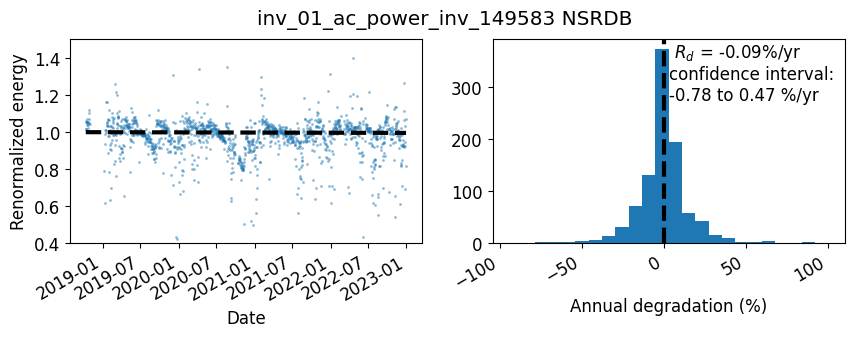

In [23]:
ta = rdtools.TrendAnalysis(inv1_qa,
                           nsrdb_poa['poa_global'],
                           temperature_ambient=(temperature_qa-32)*(5/9), # convert from F
                           gamma_pdc = -0.0041, # from data sheet
                           windspeed=df_env['wind_speed_o_149576'].asfreq('60T'),
                           temperature_model='open_rack_glass_polymer'
                           )
ta.filter_params.pop('clip_filter')
ta.sensor_analysis(yoy_kwargs={'confidence_level':95})
fig = ta.plot_degradation_summary('sensor', summary_title='inv_01_ac_power_inv_149583 NSRDB', scatter_ymin=0.4, scatter_ymax=1.5)
ax1, ax2 = fig.get_axes()
ax1.collections[0].set_linewidth(0)

# Discrepancy between NSRDB and sensor results

## Systematic differences suggest irradiance sensor drift over time
More in depth study required to confirm the details

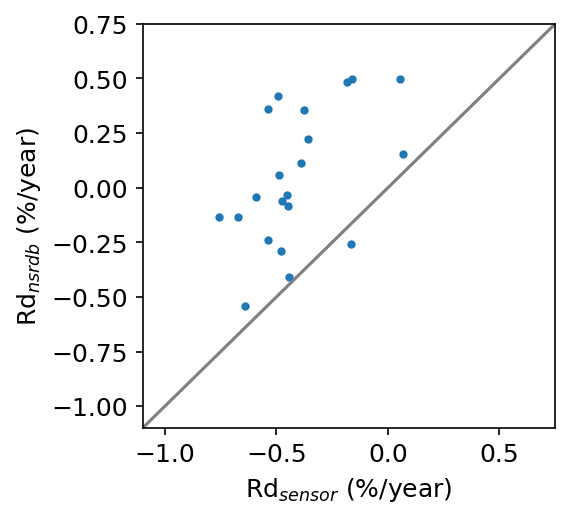
(DC degradation, axes modified to remove outliers)